<a href="https://colab.research.google.com/github/gsdxliusu/fashion-mnist/blob/main/CGAN_CC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("TF version:",tf.__version__)
#检测TensorFlow是否支持GPU
print("GPU is","available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")




TF version: 2.8.0
GPU is available


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import glob
 
from IPython import display

In [ ]:
#导入fashion-mnist数据集
fashion_mnist = tf.keras.datasets.fashion_mnist#已集成相关数据集
(train_images,train_labels),(test_images,test_labels) = fashion_mnist.load_data()#导入数据


print(train_images.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)


In [ ]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images - 127.5)/127.5  #将图片标准化到[-1,1]区间内

print(train_images.shape)
#将标签进行独热编码
train_labels = tf.one_hot(train_labels,depth = 10)
train_labels = tf.cast(train_labels,tf.float32)


(60000, 28, 28, 1)


In [ ]:
buffer_size = 60000
batch_size = 256

In [ ]:
#批量化和打乱数据
train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(buffer_size).batch(batch_size)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias = False,input_shape = (110,))) #因为加入了标签信息，input_shape发送改变
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None,7,7,256)  #注意： batch size未限制
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides = (1,1),padding = 'same',use_bias = False))
    assert model.output_shape == (None,7,7,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    model.add(layers.Conv2DTranspose(64,(5,5),strides = (2,2),padding = 'same',use_bias = False))
    assert model.output_shape == (None,14,14,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1,(5,5),strides = (2,2),padding = 'same',use_bias = False,activation = 'tanh'))
    assert model.output_shape == (None,28,28,1)
    
    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1379840   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides = (2,2),padding = 'same',input_shape = [28,28,11])) # input_shape加入了标签信息   
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128,(5,5),strides = (2,2),padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
   
    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        17664     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss+fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,discriminator_optimizer = discriminator_optimizer,generator = generator,discriminator = discriminator)

In [ ]:
epochs = 100
noise_dim = 100
num_examples_to_generate = 100


In [ ]:
#后面将重复使用该种子 （因此在动画GIF中更容易可视化进度
seed = tf.random.normal([num_examples_to_generate,noise_dim])
print(seed.shape)

#有规律设置标签
labels = [i%10 for i in range(num_examples_to_generate)] #舒适化标签向量

labels = tf.one_hot(labels,depth = 10) #将标签独热编码
print(labels.shape)
labels = tf.cast(labels,tf.float32) #转换为tf.float32类型
print(labels.shape)
seed = tf.concat([seed,labels],1) #和图像数据连接起来作为后面的输入数据
print(seed.shape)


(100, 100)
(100, 10)
(100, 10)
(100, 110)


In [ ]:

#  注意  'tf.function'的使用，该注解使函数被“编译”
@tf.function
def train_step(data_batch):
    
    
    images = data_batch[0] # 图像数据
    labels = data_batch[1] # 标签数据
    print(labels.shape)
    print(images.shape)
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        noise = tf.random.normal([images.get_shape()[0], noise_dim]) # 产生噪音图像
        print(images.get_shape()[0])

        print(noise.shape)
        noise_input = tf.concat([noise,labels],1)        # 噪音图像数据连接标签数据
        generated_images = generator(noise_input,training = True) # 生成图像
        
        labels_input = tf.reshape(labels,[images.get_shape()[0],1,1,10])
        
        images_input = tf.concat([images,labels_input*tf.ones([images.get_shape()[0],28,28,10])],3)
        # 生成图像数据连接上标签数据
        generated_input = tf.concat([generated_images,labels_input*tf.ones([images.get_shape()[0],28,28,10])],3)
        
        real_output = discriminator(images_input,training = True) # 真实图像的判决结果
        fake_output = discriminator(generated_input,training = True) # 生成图像的判决结果
        
        gen_loss = generator_loss(fake_output)  # 计算生成器损失
        disc_loss = discriminator_loss(real_output,fake_output) # 计算判别器损失
        
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables) # 求梯度
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
      # 优化变量
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))






In [ ]:
def train(dataset,epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for data_batch in dataset:
            train_step(data_batch)
        
        #生成图片
        display.clear_output(wait = True)
        generate_and_save_images(generator,epoch+1,seed)
        
        #每5 epochs进行一次存储
        if(epoch+1) % 5 ==  0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print('Time for epoch {} is {} sec'.format(epoch+1,time.time()-start))


In [ ]:
def generate_and_save_images(model,epoch,test_input):
    # 注意 'training' 设定值为False 
    # 因此，所有层都在推理模式下运行（batchnorm）。
    
    predictions = model(test_input,training = False)
    
    fig = plt.figure(figsize = (10,10))
    
    for i in range(predictions.shape[0]):
        plt.subplot(10,10,i+1)
        plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap = 'gray')
        plt.axis('off')
        
    plt.savefig('Cimage_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
   

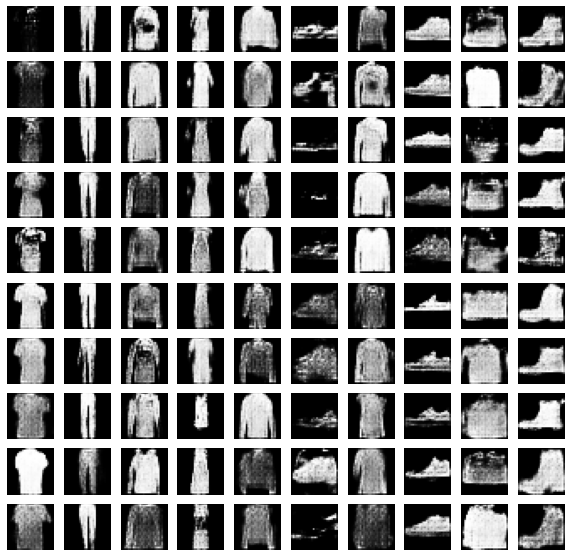

Time for epoch 100 is 17.351924419403076 sec
CPU times: user 10min 25s, sys: 26.6 s, total: 10min 52s
Wall time: 29min 14s


In [ ]:

%%time
train(train_dataset,epochs)


In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('Cimage_at_epoch_{:04d}.png'.format(epoch_no))

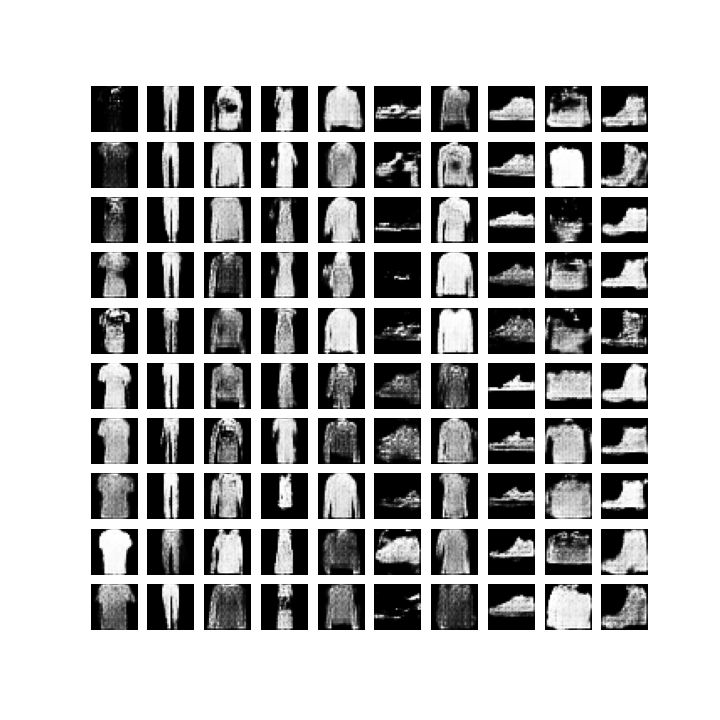

In [ ]:
display_image(epochs)

In [ ]:
import imageio
import glob
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file,mode = 'I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    
